# <font color='tomato'>Unsupervised Learning in Satellite Imagery using Python</font>

In [2]:
!pip install earthpy gdal

# Import Modules

In [3]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [4]:
%cd /content/drive/My Drive/Satellite_data


/content/drive/My Drive/Satellite_data


# Read Data

In [5]:
S_sentinel_bands = glob("/content/drive/MyDrive/Satellite_data/sundarbans_data/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/sundarbans_data/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/content/drive/MyDrive

In [6]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))


In [7]:
arr_st = np.stack(l)

In [8]:
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 954
Width: 298
Bands: 12


# Visualize Data

## Bands

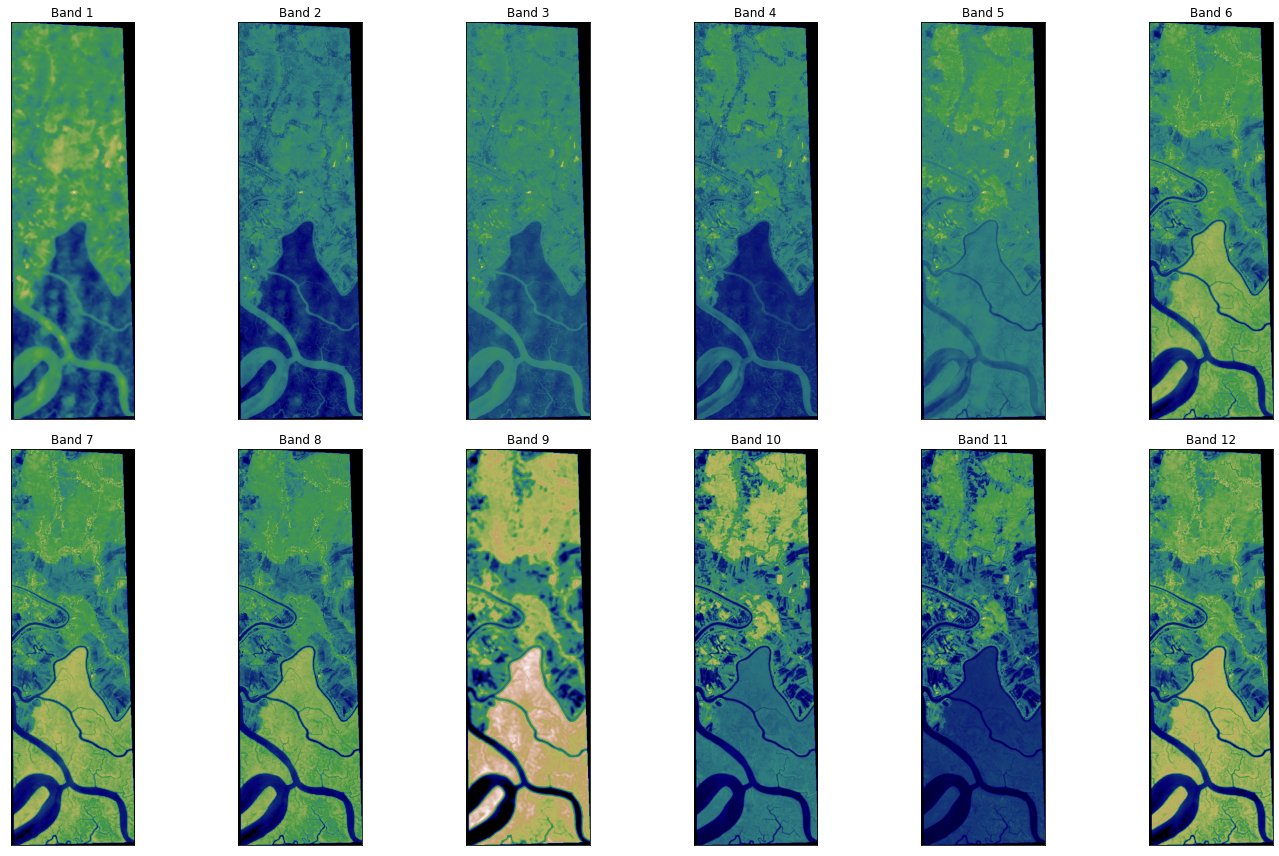

In [8]:
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 6, cbar = False)
plt.show()

## RGB Composite Image

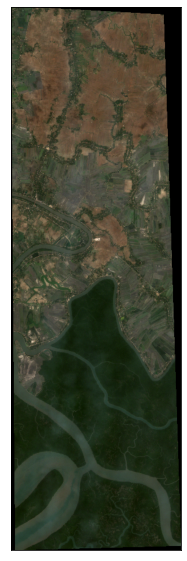

In [9]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(8, 10), 
                  # title='RGB Composite Image'
                  )

plt.show()

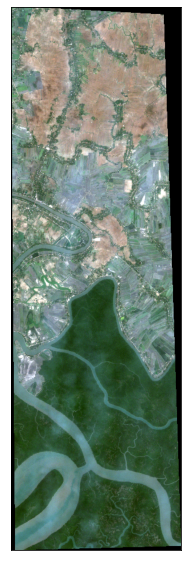

In [10]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

## Data Distribution of Bands

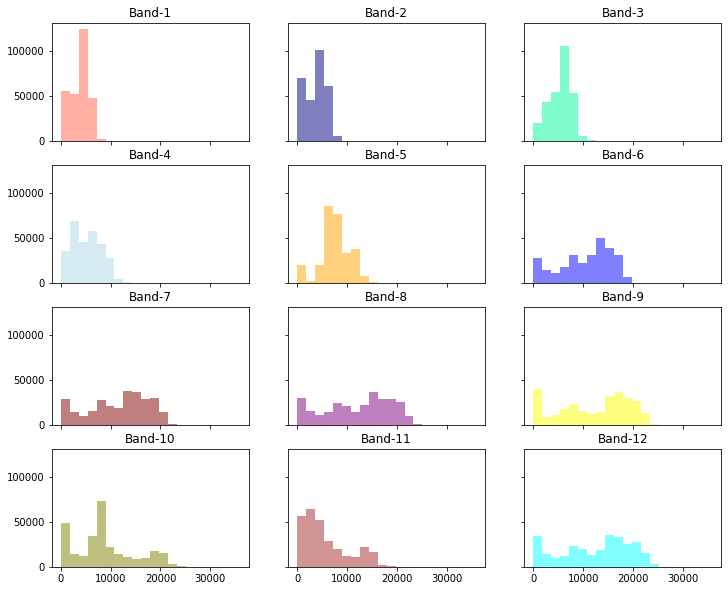

In [11]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(arr_st, 
         colors = colors,
        title=[f'Band-{i}' for i in range(1, 13)], 
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

# Preprocessing 

In [9]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(954, 298, 12)

In [10]:
x.reshape(-1, 12).shape, 954*298

((284292, 12), 284292)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_data = x.reshape(-1, 12)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(284292, 12)

## Principal Component Analysis (PCA)

In [12]:
pca = PCA(n_components = 4)

pca.fit(X_scaled)

data = pca.transform(X_scaled)

In [13]:
data.shape

(284292, 4)

In [14]:
pca.explained_variance_ratio_

array([0.55778198, 0.37521242, 0.0484222 , 0.00637526])

In [14]:
np.sum(pca.explained_variance_ratio_)

0.9877918653349008

## Visualize Bands after PCA

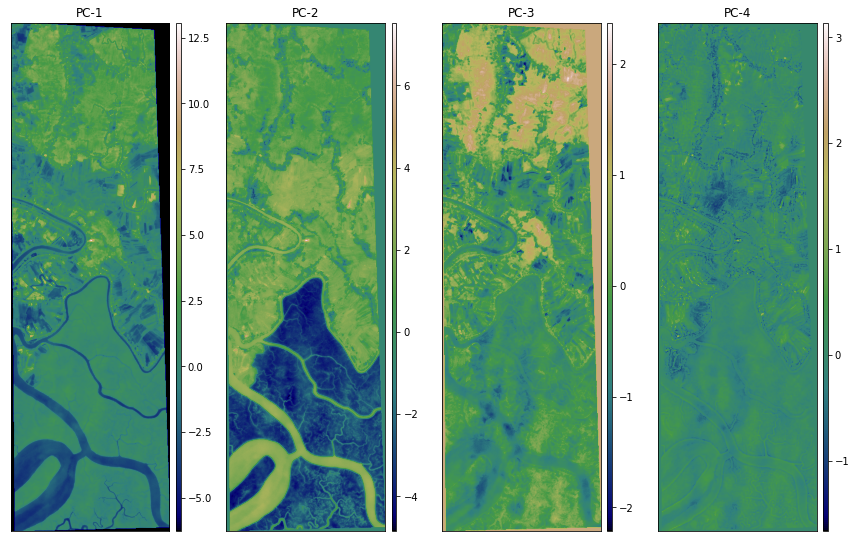

In [20]:
ep.plot_bands(np.moveaxis(data.reshape((954, 298, data.shape[1])), -1, 0),
              cmap = 'gist_earth',
              cols = 4,
              title = [f'PC-{i}' for i in range(1,5)])

plt.show()

# *k* - Means 

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 6, random_state = 11)

kmeans.fit(data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=11, tol=0.0001, verbose=0)

In [19]:
labels = kmeans.predict(data)

In [26]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

## Visualize Clusters

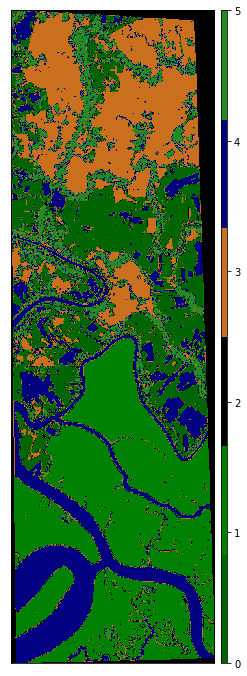

In [30]:
ep.plot_bands(labels.reshape(954, 298), cmap=ListedColormap(['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

Interactive plot using Plotly

In [56]:
import plotly.express as px

fig = px.imshow(labels.reshape(954, 298), 
          color_continuous_scale = ['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen'])

fig.update_xaxes(showticklabels=False)

fig.update_yaxes(showticklabels=False)

fig.update_layout(
    autosize=False,
    width=500,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    # paper_bgcolor="LightSteelBlue",
)



---

